In [1]:
import numpy as np
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, Flatten
from keras.optimizers import Adam
import pandas as pd
from arch import arch_model
from matplotlib import pyplot as plt
from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.metrics import mean_squared_error,mean_absolute_percentage_error, r2_score, mean_absolute_error
from tensorflow import keras
from keras.wrappers.scikit_learn import KerasRegressor
from keras import backend as K


In [2]:
def read_data(window=22):
    price = pd.read_csv('dataset/kospi.csv')
    oil = pd.read_csv('dataset/oilprice.csv')
    # gold = pd.read_csv('dataset/goldprice.csv')
    data = pd.DataFrame()
    data['Date'] = price['Date']
    data['Daily_trading_range'] = price['High'] - price['Low']
    data['Log_Volume_change'] = np.log((price['Volume'] / price['Volume'].shift(1))) * 100
    data['Daily_return'] = price['Close'].pct_change().dropna()
    data['Daily_log_return'] = np.log(price['Close'] / price['Close'].shift(1))
    data['Index'] = price['Close']
    # data['gold'] = gold['Close']
    data['oil'] = oil['Close']
    data = data.dropna().reset_index(drop=True)

    data = data.iloc[:-window]
    print(data['Daily_log_return'])
    volatility = np.sqrt((data['Daily_log_return'] ** 2).rolling(window=window).sum() / window) * np.sqrt(252)

    # target = yz_vol_measure(data)
    # target10 = yz_vol_measure(data, window=10)
    target = pd.DataFrame()
    target['Target'] = volatility[window:].reset_index(drop=True)
    # target['Target'] = volatility[22:].reset_index(drop=True)
    target = target.dropna()

    # data['Target10'] = target10
    # data = data.dropna()

    return data, target

In [3]:
def evaluate(predict, target, title):
    print('--------'+title+'----------')
    testScore = mean_squared_error(predict, target)
    print("test Score: {score} MSE".format(score=testScore))
    root_testScore = mean_squared_error(y_pred=predict, y_true=target, squared=False)
    print("test Score: {score} RMSE".format(score=root_testScore))
    mape = mean_absolute_percentage_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAPE".format(score=mape))
    mae = mean_absolute_error(y_pred=predict, y_true=target)
    print("test Score: {score} MAE".format(score=mae))
    r2_test = r2_score(y_true=target, y_pred=predict)
    print("test Score: {score} R2 score".format(score=r2_test))

In [4]:
def plot(predict, target, title, save=False):
    plt.plot(predict, label='predict')
    plt.plot(target, label='target')
    plt.title(title)
    plt.legend()
    if save:
        plt.savefig('images/'+title)
    plt.show()

In [5]:
def ewma_estimation(data):
    sqreturn = np.array(data['Daily_log_return']**2)
    estimation = []
    estimation.append(data['Past_vol22'].iloc[0] / np.sqrt(252))
    weight = 0.94
    for i in range(1,len(data)):
        pred = weight*(estimation[-1]**2) + (1-weight)*(sqreturn[i-1])
        estimation.append(np.sqrt(pred))

    estimation = np.sqrt(252)*pd.DataFrame(estimation, columns=['EWMA'])

    # plot(estimation, np.array(data['Target22']))
    print('-----EWMA estimation done-----')
    return estimation

In [6]:
def create_gjr(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']].dropna())
    arr_target = np.array(target)
    gjr_pred = []
    mean_target = []
    for i in range(len(target)-n_ahead):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
    for i in range(len(logreturns)-window-n_ahead):
        train = logreturns[:i+window] * 100
        gm = arch_model(train, p=1, q=1, o=1)
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        gjr_pred.append(np.sqrt(pred.variance.values[-1, :].mean()) * 0.01 * np.sqrt(252))

    print('garch pred length: ', len(gjr_pred))
    print('target length: ', len(mean_target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(gjr_pred, mean_target, title)
    gjr_pred = pd.DataFrame(gjr_pred, columns=['GJR'])
    print('-----GJR-GARCH estimation done-----')
    return gjr_pred

In [7]:
def create_garch(data, target, window=22, n_ahead=1):
    logreturns = np.array(data[['Daily_log_return']])
    arr_target = np.array(target)
    garch_pred = []
    mean_target = []
    for i in range(len(target)-n_ahead):
        window_target = arr_target[i:i+n_ahead]
        mean_target.append(window_target.mean())
    for i in range(len(logreturns)-window-n_ahead):
        train = logreturns[:i+window]*100
        gm = arch_model(train, p=1, q=1)
        gm_fit = gm.fit(disp='off')
        pred = gm_fit.forecast(horizon=n_ahead)
        garch_pred.append(np.sqrt(pred.variance.values[-1,:].mean())*0.01*np.sqrt(252))

    print('garch pred length: ', len(garch_pred))
    print('target length: ', len(mean_target))
    title = 'GARCH prediction, window={}, n_ahead={}'.format(window, n_ahead)
    plot(garch_pred, mean_target, title)
    garch_pred = pd.DataFrame(garch_pred, columns=['GARCH'])
    print('-----GARCH estimation done-----')
    return garch_pred

In [8]:
def data_prep(data, target, split_index, status=0, n_ahead=1, window=22):
    extras=pd.DataFrame()

    data = data.drop(['Daily_return','Date'], axis=1)

    window = window
    n_ahead = n_ahead
    y_values = target
    x_values = data
    print(x_values.info())

    scaler = MinMaxScaler()
    scaled_x = scaler.fit_transform(x_values)
    scaled_y = scaler.fit_transform(y_values)

    if(status==1):
        extras['GARCH'] = data['GARCH'].dropna()

    elif(status==2):
        extras['GJR'] = data['GJR'].dropna()

    elif(status==3):
        extras['GARCH'] = data['GARCH'].dropna()
        extras['GJR'] = data['GJR'].dropna()

    trainX = np.array(scaled_x[:split_index])
    testX = np.array(scaled_x[split_index:])
    trainY = np.array(scaled_y[:split_index])
    testY = np.array(scaled_y[split_index:])

    Xtrain = np.array([])
    ytrain = np.array([])
    Xtest = np.array([])
    ytest = np.array([])

    for i in range(window, len(trainX)-n_ahead-window):
        candidate = trainX[i - window:i, :trainX.shape[1]]
        if(status==1):
            candidate[:,-1] = extras['GARCH'].iloc[i-window]
        elif(status==2):
            candidate[:,-1] = extras['GJR'].iloc[i-window]
        elif(status==3):
            candidate[:,-1] = extras['GARCH'].iloc[i-window]
            candidate[:,-2] = extras['GJR'].iloc[i-window]

        candidate = candidate.reshape(1, candidate.shape[0], candidate.shape[1])
        y_candidate = trainY[i-window:i-window+n_ahead].reshape(1, trainY[i-window:i-window+n_ahead].shape[0], trainY[i:i+n_ahead].shape[1])

        if i==window:
            Xtrain = candidate
            ytrain = y_candidate
            continue

        Xtrain = np.append(Xtrain, candidate, axis=0)
        ytrain = np.append(ytrain, y_candidate, axis=0)
        # ytrain.append(trainY[i:i+n_ahead])

    for i in range(window, len(testX)-n_ahead-window):
        test_candidate = testX[i - window:i, :testX.shape[1]]
        if(status==1):
            test_candidate[:,-1] = extras['GARCH'].iloc[split_index+i-window]
        elif(status==2):
            test_candidate[:,-1] = extras['GJR'].iloc[split_index+i-window]
        elif(status==3):
            test_candidate[:,-1] = extras['GARCH'].iloc[split_index+i-window]
            test_candidate[:,-2] = extras['GJR'].iloc[split_index+i-window]
        test_candidate = test_candidate.reshape(1, test_candidate.shape[0], test_candidate.shape[1])
        test_y_can = testY[i-window:i-window+n_ahead].reshape(1, testY[i-window:i-window+n_ahead].shape[0], testY[i-window:i-window+n_ahead].shape[1])

        if(i==window):
            Xtest = test_candidate
            ytest = test_y_can
            continue
        Xtest = np.append(Xtest, test_candidate, axis=0)
        ytest = np.append(ytest, test_y_can, axis=0)

        # Xtest.append(test_candidate)
        # ytest.append(testY[i:i+n_ahead])
    # Xtrain, ytrain = (np.array(Xtrain), np.array(ytrain))
    # Xtrain = np.reshape(Xtrain, (Xtrain.shape[0], Xtrain.shape[1], Xtrain.shape[2]))
    #
    # Xtest, ytest = (np.array(Xtest), np.array(ytest))
    # Xtest = np.reshape(Xtest, (Xtest.shape[0], Xtest.shape[1], Xtest.shape[2]))

    print(Xtrain.shape)
    print(ytrain.shape)
    print("-----")
    print(Xtest.shape)
    print(ytest.shape)
    return Xtrain, ytrain, Xtest, ytest, scaler

In [9]:
def create_lstm(dropout1=0, output=1):
    model = Sequential()
    model.add(LSTM(units=64, return_sequences=False, input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dropout(dropout1))
    # model.add(LSTM(units=32, return_sequences=False))
    # model.add(Dropout(dropout2))
    # model.add(LSTM(units=20, return_sequences=False))
    # model.add(Dropout(dropout3))
    # model.add(Dense(20, activation='tanh'))
    model.add(Dense(output))
    # model.add(Dense(1))
    opt = keras.optimizers.Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=opt)

    return model

In [10]:
def create_ann(output=1):
    model = Sequential()
    model.add(Flatten(input_shape=(Xtrain.shape[1], Xtrain.shape[2])))
    model.add(Dense(64, activation='tanh'))
    model.add(Dropout(0.3))
    model.add(Dense(32, activation='tanh'))
    model.add(Dropout(0.1))
    model.add(Dense(20, activation='tanh'))
    model.add(Dropout(0.5))
    model.add(Dense(output))
    adam = Adam(learning_rate=0.001)
    model.compile(loss='mae', optimizer=adam)
    return model

In [11]:
def run_lstm(Xtrain, ytrain, Xtest, ytest, scaler):
    lstm = create_lstm(Xtrain)
    lstm_fit = lstm.fit(Xtrain, ytrain, batch_size=16, epochs=150)
    lstm_forecast = lstm.predict(Xtest)

    rev_forecast = scaler.inverse_transform(lstm_forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plot(rev_forecast, rev_ytest)
    evaluate(rev_forecast, rev_ytest, 'LSTM Evaluation')

In [12]:
def run_ann(Xtrain, ytrain, Xtest, ytest, scaler):
    model = create_ann(Xtrain)
    model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)
    forecast = model.predict(Xtest)

    rev_forecast = scaler.inverse_transform(forecast)
    rev_ytest = scaler.inverse_transform(ytest)

    plt.plot(rev_forecast, color='red', label='forecast')
    plt.plot(rev_ytest, color='gold', label='target')
    plt.legend()
    plt.show()
    evaluate(rev_forecast, rev_ytest, 'GER-FNN evaluation')

In [14]:
data, target = read_data(22)

split_index = int(len(data)*0.8)
print('Split index: ',split_index)
print('Observations: ', len(data))

0       0.007249
1      -0.001243
2      -0.002375
3       0.004126
4      -0.002587
          ...   
2401    0.019042
2402    0.005812
2403   -0.006215
2404    0.009324
2405    0.002867
Name: Daily_log_return, Length: 2406, dtype: float64
Split index:  1924
Observations:  2406


In [15]:
data

,Date,Daily_trading_range,Log_Volume_change,Daily_return,Daily_log_return,Index,oil
0,2011-01-04,16.019776,16.086549,0.007275,0.007249,2085.139893,88.000000
1,2011-01-05,10.219971,-7.434844,-0.001242,-0.001243,2082.550049,89.190002
2,2011-01-06,30.549804,5.468045,-0.002372,-0.002375,2077.610107,89.379997
3,2011-01-07,17.540039,-19.485688,0.004134,0.004126,2086.199951,88.690002
4,2011-01-10,19.339844,2.064361,-0.002584,-0.002587,2080.810059,88.279999
...,...,...,...,...,...,...,...
2401,2020-11-23,51.880127,37.886469,0.019225,0.019042,2602.590088,41.700001
2402,2020-11-24,23.489991,-18.932034,0.005829,0.005812,2617.760010,42.189999
2403,2020-11-25,58.850098,3.287256,-0.006196,-0.006215,2601.540039,41.950001
2404,2020-11-26,33.540039,-1.622913,0.009367,0.009324,2625.909912,41.220001


In [16]:
target

,Target
0,0.114448
1,0.121056
2,0.135732
3,0.145106
4,0.158118
...,...
2379,0.191057
2380,0.191888
2381,0.191501
2382,0.193158


garch pred length:  2374
target length:  2374
-----GARCH estimation done-----
garch pred length:  2374
target length:  2374
-----GJR-GARCH estimation done-----
         GARCH
0     0.143843
1     0.141074
2     0.145388
3     0.159801
4     0.165653
...        ...
2369  0.193367
2370  0.192342
2371  0.182835
2372  0.184208
2373  0.176243

[2374 rows x 1 columns]
           GJR
0     0.143850
1     0.141076
2     0.145389
3     0.161953
4     0.191262
...        ...
2369  0.162585
2370  0.157468
2371  0.152407
2372  0.147975
2373  0.145090

[2374 rows x 1 columns]


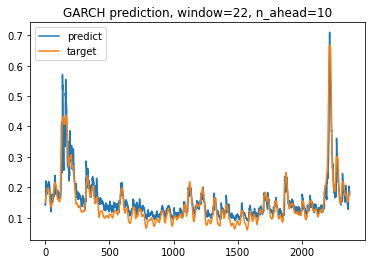

c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "
c:\users\user\cxk858\cxk858\lib\site-packages\scipy\optimize\optimize.py:282: RuntimeWarning: Values in x were outside bounds during a minimize step, clipping to bounds
  warnings.warn("Values in x were outside bounds during a "


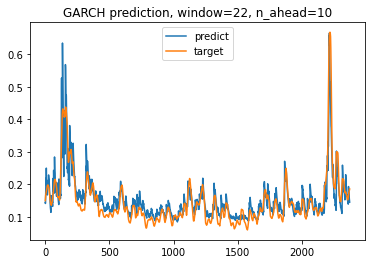

In [26]:

garch_estim = create_garch(data, target, window=22, n_ahead=10)
gjr_estim = create_gjr(data, target, window=22, n_ahead=10)
print(garch_estim)
print(gjr_estim)

In [27]:
data_g = data.copy()
data_g['GARCH'] = garch_estim['GARCH']
data_r = data.copy()
data_r['GJR'] = gjr_estim['GJR']
data_gr = data.copy()
data_gr['GJR'] = gjr_estim['GJR']
data_gr['GARCH'] = garch_estim['GARCH']

In [28]:
Xtrain, ytrain, Xtest, ytest, scaler = data_prep(data_gr, target, split_index, status=3,n_ahead=10, window=22)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2406 entries, 0 to 2405
Data columns (total 7 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Daily_trading_range  2406 non-null   float64
 1   Log_Volume_change    2406 non-null   float64
 2   Daily_log_return     2406 non-null   float64
 3   Index                2406 non-null   float64
 4   oil                  2406 non-null   float64
 5   GJR                  2374 non-null   float64
 6   GARCH                2374 non-null   float64
dtypes: float64(7)
memory usage: 131.7 KB
None
(1870, 22, 7)
(1870, 10, 1)
-----
(428, 22, 7)
(428, 10, 1)


In [20]:
# Xtest
data_g['GARCH'].tail(50)

2356    0.138666
2357    0.134588
2358    0.132905
2359    0.127423
2360    0.127253
2361    0.125067
2362    0.123385
2363    0.124907
2364    0.174953
2365    0.180033
2366    0.193078
2367    0.184719
2368    0.209736
2369    0.197931
2370    0.196797
2371    0.186286
2372    0.187802
2373    0.178967
2374    0.173117
2375    0.189518
2376    0.179509
2377    0.170443
2378    0.161673
2379    0.153894
2380    0.173072
2381    0.166406
2382    0.161065
2383         NaN
2384         NaN
2385         NaN
2386         NaN
2387         NaN
2388         NaN
2389         NaN
2390         NaN
2391         NaN
2392         NaN
2393         NaN
2394         NaN
2395         NaN
2396         NaN
2397         NaN
2398         NaN
2399         NaN
2400         NaN
2401         NaN
2402         NaN
2403         NaN
2404         NaN
2405         NaN
Name: GARCH, dtype: float64

In [30]:
# model = create_lstm(0.6, output=22)
model = create_ann(output=10)
model_fit = model.fit(Xtrain, ytrain, batch_size=16, epochs=50)

Epoch 1/50
117/117 [==============================] - 1s 1ms/step - loss: 0.3492
Epoch 2/50
117/117 [==============================] - 0s 1ms/step - loss: 0.1072
Epoch 3/50
117/117 [==============================] - 0s 1ms/step - loss: 0.0739
Epoch 4/50
117/117 [==============================] 

In [31]:
print(Xtrain.shape)
print(ytrain.shape)
print(Xtest.shape)
print(ytest.shape)

(1870, 22, 7)
(1870, 10, 1)
(428, 22, 7)
(428, 10, 1)


In [32]:
forecast = model.predict(Xtest)

In [33]:
forecast = forecast.mean(axis=1).reshape(len(forecast),1)
ytest = ytest.mean(axis=1).reshape(len(ytest),1)

print(forecast.shape)
print(ytest.shape)

(428, 1)
(428, 1)


In [34]:
rev_forecast = scaler.inverse_transform(forecast)
rev_ytest = scaler.inverse_transform(ytest)

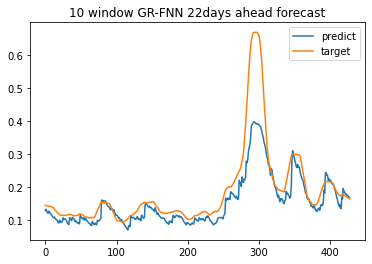

In [35]:
title = '10 window GR-FNN 22days ahead forecast'
plot(rev_forecast, rev_ytest, title, save=True)

In [36]:
evaluate(rev_forecast, rev_ytest, 'ANN')

--------ANN----------
test Score: 0.004436786609843023 MSE
test Score: 0.06660920814604407 RMSE
test Score: 0.15801291474127918 MAPE
test Score: 0.03624998689873255 MAE
test Score: 0.6938909271176865 R2 score


In [325]:
garch_test = garch_estim.iloc[split_index:]
gjr_test = gjr_estim.iloc[split_index:]
garch_y = target[split_index:]

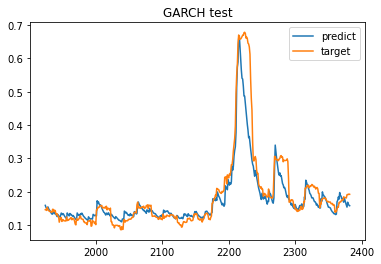

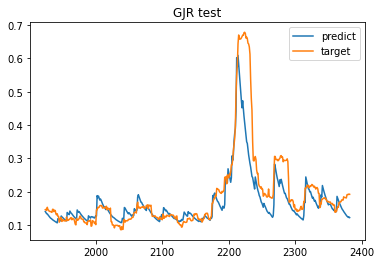

In [326]:
plot(garch_test, garch_y, 'GARCH test', False)
plot(gjr_test, garch_y, 'GJR test', False)

In [327]:
evaluate(garch_test, garch_y, 'GARCH eval')
evaluate(gjr_test, garch_y, 'GJR eval')

--------GARCH eval----------
test Score: 0.002238804654568591 MSE
test Score: 0.047316008438673174 RMSE
test Score: 0.11476430445058863 MAPE
test Score: 0.02500444425902648 MAE
test Score: 0.8431910513332512 R2 score
--------GJR eval----------
test Score: 0.0038343288711509757 MSE
test Score: 0.06192195790792613 RMSE
test Score: 0.14417166948803575 MAPE
test Score: 0.03289158553722205 MAE
test Score: 0.7314383468424555 R2 score
